In [8]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
from src.preprocessing.load_data import *
from src.preprocessing.process_softchirp_features import find_outliers, choose_features
from src.data_representations.softchirp_features import compute_all_features
from src.data_representations.process_traces import clear_trace
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.visualization.plot_softchirps import plot
from src.util import delete_indexes
import src.visualization.plot_softchirps
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS # change plotting_config file to change colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

### Parameter selection

In [9]:
# specify paths, where data is stored
path_to_info = PATH_TO_PROJECT + 'data/rat_info.csv'
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = ['baratheon','dothrakib', 'martell', 'targaryen']
#colonies = 'all'
dates = 'all'
experiments = ['single rat softchirps']
stages = ['traced and checked',]

# specifies seconds to pixels ratio for spectrogram image
# uses librosa library which downsamples all audio files to 22050
freq_mult = 22050 / 2  / 128

# specify outliers,soft chirp traces outside of these ranges are excluded from analysis  
boundaries = {'slope' : (0.01, .2), 
              'frequency' : (2000, 8000), 
              'duration' : (0.05, 10),
              'height' : (300, 6000)}

In [10]:
path_to_info

'/home/nakedmoleratvoices/data/rat_info.csv'

### Load data

In [11]:
# load info- and meta- data
info = load_info_file(path_to_info)
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})

# filter what will be used (this is specified above)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_to_analyse = recs_metadata[mask]

# load recording wavs, sound wavs and traces, create sounds metadata (master file)
recs_dict = load_recs_dict(recs_to_analyse)
traces, wavs, sounds_metadata = load_traces_wavs_and_metadata(recs_to_analyse, info, recs_dict)
sounds_metadata_extended = extend_sounds_metadata(sounds_metadata, info)
traces = [clear_trace(t, ) for t in traces]

# compute softchirp features
features, inds_skipped = compute_all_features(traces, wavs, freq_mult)
traces, wavs, sounds_metadata_extended = delete_indexes(inds_skipped, traces, wavs, sounds_metadata_extended)

# compute epochs 
sounds_metadata_extended = compute_epochs(sounds_metadata_extended, EPOCHS)

# remove outliers
outliers = find_outliers(features, boundaries )
features, sounds_metadata_extended = delete_indexes(outliers, features, sounds_metadata_extended)
print('Features could not be extracted from %d traces' % len(inds_skipped))
print('%d traces were deleted as outliers' %  len(outliers))
print('%d traces are left' % (len(sounds_metadata_extended)))

/home/nakedmoleratvoices/src/preprocessing/process_sounds_metadata.py:62: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat([sounds_metadata.reset_index(drop = True), columns_to_add], 1)
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1449
  n_fft, y.shape[-1]


Features could not be extracted from 0 traces
26 traces were deleted as outliers
3337 traces are left


In [12]:
save_excel = False
#save_path  = '' 
# creates master list of data as an excel file
all_data_table = pd.concat([sounds_metadata_extended, features], 1)
# save
if save_excel:
    all_data_table.to_excel('all_data!.xlsx')
all_data_table.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  after removing the cwd from sys.path.


,rec,colony,date,ratids,experiment,s,e,cl,weight,sex,...,epoch,slope,frequency,pitch,amplitude,wiener_entropy,zero_crossings,duration,height,asymmetry
0,targaryen_21-06-19_1540_0000001.npy,targaryen,21-06-19,1540,single rat softchirps,38.445442,38.642948,softchirp,62.7,M,...,?,0.050395,4348.797681,5298.086045,0.107940,0.234248,0.420436,0.144331,1981.054688,-172.265625
1,targaryen_21-06-19_1540_0000001.npy,targaryen,21-06-19,1540,single rat softchirps,42.954558,43.194649,softchirp,62.7,M,...,?,0.053602,4488.295164,9015.735580,0.185051,0.261715,0.439932,0.160060,2239.453125,-258.398438
2,targaryen_21-06-19_1540_0000001.npy,targaryen,21-06-19,1540,single rat softchirps,21.220499,21.416735,softchirp,62.7,M,...,?,0.042801,4326.933342,4739.388805,0.118480,0.160265,0.431477,0.180845,2411.718750,-1033.593750
3,targaryen_21-06-19_1540_0000001.npy,targaryen,21-06-19,1540,single rat softchirps,40.351610,40.552880,softchirp,62.7,M,...,?,0.062598,4387.518752,3927.325394,0.084663,0.174798,0.411221,0.123858,1464.257812,-172.265625
4,targaryen_21-06-19_1540_0000001.npy,targaryen,21-06-19,1540,single rat softchirps,16.570612,16.821678,softchirp,62.7,M,...,?,0.053992,4635.038861,5137.503490,0.110936,0.284392,0.429733,0.144553,1722.656250,-258.398438


### Plotting

Keys:  ['rec', 'colony', 'date', 'ratids', 'experiment', 's', 'e', 'cl', 'weight', 'sex', 'rank', 'dob', 'age', 'bodylength', 'bodylength2', 'epoch']


/home/nakedmoleratvoices/src/util.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(indexes)


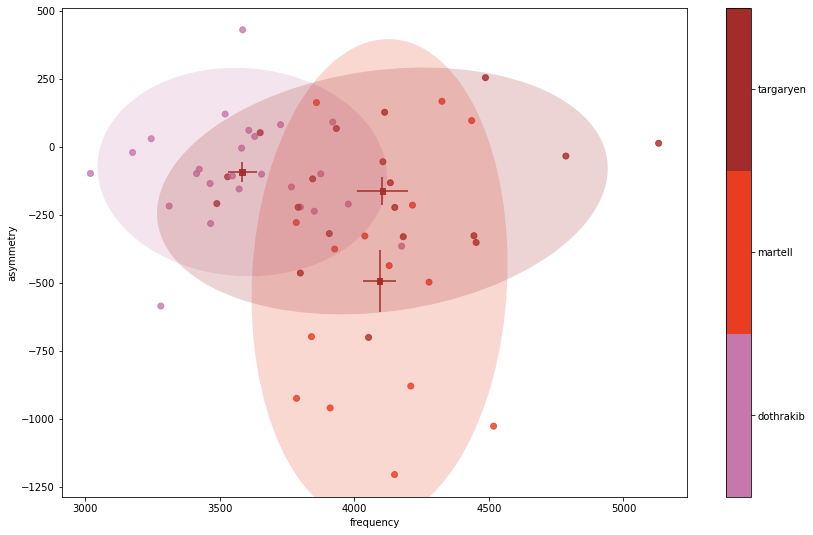

In [13]:

# specify what is plotted
print('Keys: ', list(sounds_metadata_extended.columns))
# specify filters
colonies = ['baratheon','dothrakib', 'martell', 'targaryen']
weights = 'all'
dates = 'all'
sexes = 'all' # options: 'M', 'F', or 'all'
ages = 'all' # set range: (0, np.inf)
ranks = 'all' 
ratids =  'all'
excludeids = None # options: '1111', or None
bodylengths = 'all'# or set range
bodylengths2 = 'all' # or set range
sounds_per_rat = [0, 10000]
types = 'all'# options for types: 'single', 'pairs', or 'all'

# how to plot
color_by = 'colony' #specfies color option in graph
#options = 'colony', 'age', 'weight'
features_to_plot = ['frequency', 'asymmetry']
#features_to_plot = 'pca' #can make PCA ot tSNE plots of all features
perplexity = 50 #only required for tSNE

group_by_rat = True # plots mean values for each animal
plot_color_mean = True # plots mean for color_by grouping (i.e. colony)
group_color_column = None
plot_ellipses = True # plots ellipses representing 95% confidence intervals


order = ORDER[color_by]
color_dict = COLOR[color_by]


mask =  filter_sounds_metadata_extended(sounds_metadata_extended, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
features_masked = features[mask]
sounds_metadata_masked = sounds_metadata_extended[mask]
y = sounds_metadata_masked[color_by]


plot(features_masked, y, sounds_metadata_masked, features_to_plot, perplexity,
     group_by_rat, group_color_column, plot_ellipses, plot_color_mean,
     color_dict, order, sizes_factor = 32)